In [1]:
import random 
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

plt.style.use('ggplot')

output_to_predict = "pressure"
columns = ['R', 'C', 'u_in', 'u_out']

Columns

    id - globally-unique time step identifier across an entire file
    breath_id - globally-unique time step for breaths
    R - lung attribute indicating how restricted the airway is (in cmH2O/L/S). Physically, this is the change in pressure per change in flow (air volume per time). Intuitively, one can imagine blowing up a balloon through a straw. We can change R by changing the diameter of the straw, with higher R being harder to blow.
    C - lung attribute indicating how compliant the lung is (in mL/cmH2O). Physically, this is the change in volume per change in pressure. Intuitively, one can imagine the same balloon example. We can change C by changing the thickness of the balloon’s latex, with higher C having thinner latex and easier to blow.
    time_step - the actual time stamp.
    u_in - the control input for the inspiratory solenoid valve. Ranges from 0 to 100.
    u_out - the control input for the exploratory solenoid valve. Either 0 or 1.
    pressure - the airway pressure measured in the respiratory circuit, measured in cmH2O.


In [2]:
folder = "./data/20210921/"

In [3]:
dfp_train = pd.read_csv(folder + "train.csv")
dfp_test = pd.read_csv(folder + "test.csv")

In [4]:
dfp_train.iloc[0]

id            1.000000
breath_id     1.000000
R            20.000000
C            50.000000
time_step     0.000000
u_in          0.083334
u_out         0.000000
pressure      5.837492
Name: 0, dtype: float64

In [5]:
breath_ids = dfp_train["breath_id"].unique()
print("Count breath_id available:", len(breath_ids))

Count breath_id available: 75450


In [6]:
breath_id = random.choice(breath_ids)
dfp_train_breath_id = dfp_train[dfp_train["breath_id"] == breath_id]

In [7]:
def plot_breath(dfp_train_breath_id, columns=["R","C", "u_in","u_out"]):
    for column in columns:
        fig,ax=plt.subplots(figsize=(12,6))
        dfp_train_breath_id.plot(ax=ax, x="time_step", y=output, color="r")
        dfp_train_breath_id.plot(ax=ax, x="time_step", y=column, color="b", secondary_y=True)
        fig.tight_layout()
        plt.show()

In [8]:
# Make some stats on the training set
# profile = ProfileReport(dfp_train, title="Pandas profiling for the training set")
# profile.to_file("pdprofiling_traning.html")

## Analyse the features more deeply

### Work on R

In [9]:
dfp_train_R_agg = dfp_train.groupby(["breath_id"]).agg({"R" : ["mean","std","min","max"]})
dfp_train_R_agg.describe()

R                                     
               mean      std           min           max
count  75450.000000  75450.0  75450.000000  75450.000000
mean      27.036183      0.0     27.036183     27.036183
std       19.595619      0.0     19.595619     19.595619
min        5.000000      0.0      5.000000      5.000000
25%        5.000000      0.0      5.000000      5.000000
50%       20.000000      0.0     20.000000     20.000000
75%       50.000000      0.0     50.000000     50.000000
max       50.000000      0.0     50.000000     50.000000

In [10]:
dfp_train_R_agg["R", "mean"].unique()

array([20, 50,  5])

### Work on C

In [11]:
dfp_train_C_agg = dfp_train.groupby(["breath_id"]).agg({"C" : ["mean","std","min","max"]})
dfp_train_C_agg.describe()

C                                     
               mean      std           min           max
count  75450.000000  75450.0  75450.000000  75450.000000
mean      26.080716      0.0     26.080716     26.080716
std       17.152426      0.0     17.152426     17.152426
min       10.000000      0.0     10.000000     10.000000
25%       10.000000      0.0     10.000000     10.000000
50%       20.000000      0.0     20.000000     20.000000
75%       50.000000      0.0     50.000000     50.000000
max       50.000000      0.0     50.000000     50.000000

In [12]:
dfp_train_C_agg["C", "mean"].unique()

array([50, 20, 10])

In [13]:
# Dtermine if there is various combo of R and C
dfp_train_RC_agg = dfp_train.groupby("breath_id").agg({"R" : "min", "C" : "min"})
dfp_train_RC_agg["R-C"] = dfp_train_RC_agg.apply(lambda row: f'{row["R"]}-{row["C"]}', axis=1)

In [14]:
sp_train_RC = dfp_train_RC_agg.groupby(["R-C"]).size() / len(dfp_train_RC_agg)

In [16]:
dfp_test_RC_agg = dfp_test.groupby("breath_id").agg({"R" : "min", "C" : "min"})
dfp_test_RC_agg["R-C"] = dfp_test_RC_agg.apply(lambda row: f'{row["R"]}-{row["C"]}', axis=1)

In [17]:
dfp_test_RC_agg.groupby(["R-C"]).size() / len(dfp_test_RC_agg)

R-C
20-10    0.085328
20-20    0.081272
20-50    0.109344
5-10     0.108091
5-20     0.108370
5-50     0.108290
50-10    0.180537
50-20    0.109404
50-50    0.109364
dtype: float64

Build a category R-C will embeeded both

### Study of the time step

In [18]:
dfp_train_time_step_agg = dfp_train.groupby("breath_id").agg({"time_step" : ["mean","std","min","max"]})
dfp_train_time_step_agg.describe()

time_step                                     
               mean           std      min           max
count  75450.000000  75450.000000  75450.0  75450.000000
mean       1.307225      0.769146      0.0      2.614803
std        0.043396      0.025619      0.0      0.087102
min        1.248343      0.734410      0.0      2.496809
25%        1.261816      0.742316      0.0      2.523674
50%        1.326647      0.780820      0.0      2.655257
75%        1.344454      0.791259      0.0      2.689902
max        1.516630      0.872865      0.0      2.937238

duration of the breath is between 2.49 and 2.93, and start at 0

In [19]:
dfp_test_time_step_agg = dfp_test.groupby("breath_id").agg({"time_step" : ["mean","std","min","max"]})
dfp_test_time_step_agg.describe()

time_step                                     
               mean           std      min           max
count  50300.000000  50300.000000  50300.0  50300.000000
mean       1.307083      0.769061      0.0      2.614514
std        0.043345      0.025596      0.0      0.087014
min        1.248501      0.734393      0.0      2.497135
25%        1.261882      0.742352      0.0      2.523812
50%        1.321763      0.777333      0.0      2.642664
75%        1.344447      0.791257      0.0      2.689866
max        1.457647      0.863396      0.0      2.935203

### Study of the u_out

In [20]:
dfp_train_u_out_agg = dfp_train.groupby("breath_id").agg({"u_out" : ["mean","std","min","max"]})
dfp_train_u_out_agg.describe()

u_out                                
               mean           std      min      max
count  75450.000000  75450.000000  75450.0  75450.0
mean       0.620449      0.488116      0.0      1.0
std        0.014161      0.003517      0.0      0.0
min        0.600000      0.466437      0.0      1.0
25%        0.612500      0.483755      0.0      1.0
50%        0.625000      0.487177      0.0      1.0
75%        0.637500      0.490253      0.0      1.0
max        0.687500      0.492989      0.0      1.0

In [21]:
dfp_train_u_out_agg_2 = dfp_train[dfp_train["u_out"] == 1].groupby("breath_id").agg({"time_step" : "min"})
dfp_train_u_out_agg_2.describe()

,time_step
count,75450.000000
mean,1.003568
std,0.012947
min,0.822729
25%,0.993803
50%,1.000170
75%,1.014079
max,1.197332


In [22]:
dfp_test_u_out_agg_2 = dfp_test[dfp_test["u_out"] == 1].groupby("breath_id").agg({"time_step" : "min"})
dfp_test_u_out_agg_2.describe()

,time_step
count,50300.000000
mean,1.003623
std,0.012895
min,0.794037
25%,0.994786
50%,1.000198
75%,1.014022
max,1.034901


### Study of the u_in

In [23]:
dfp_train_u_in_agg = dfp_train.groupby("breath_id").agg({"u_in" : ["mean","std","min","max"]})
dfp_train_u_in_agg.describe()

u_in                                          
               mean           std           min           max
count  75450.000000  75450.000000  75450.000000  75450.000000
mean       7.321615      9.134580      0.017168     36.020079
std        5.499719      8.288959      0.116840     31.406148
min        0.000000      0.000000      0.000000      0.000000
25%        3.678597      3.049598      0.000000     11.384459
50%        5.460786      5.673089      0.000000     23.657786
75%        8.838098     13.083128      0.000000     52.871487
max       34.049446     42.289845      1.171243    100.000000

looks like the max value doesn't reach every time 100 , plenty of different value between 0 and 100

In [24]:
dfp_train_u_in_agg["u_in","max"] - dfp_train_u_in_agg["u_in","min"].sort_values()

breath_id
1          28.313036
2          13.980205
3          18.353980
4          23.969311
5          34.031274
             ...    
125740      8.309831
125742    100.000000
125743      5.302141
125745     23.588836
125749     25.504196
Length: 75450, dtype: float64

In [25]:
dfp_train_u_in_agg[dfp_train_u_in_agg["u_in","max"] < 5]

u_in                         
               mean       std  min       max
breath_id                                   
23         2.905642  1.734464  0.0  4.985978
42         2.597675  1.943004  0.0  4.990704
75         2.491973  1.989244  0.0  4.990448
94         2.311963  1.763253  0.0  4.967037
114        3.108696  1.783725  0.0  4.987028
...             ...       ...  ...       ...
125687     2.404088  1.859598  0.0  4.985918
125688     2.177570  2.019683  0.0  4.972196
125690     2.221722  1.928142  0.0  4.974378
125730     2.806619  1.819929  0.0  4.973477
125739     2.692814  1.698305  0.0  4.968770

[6097 rows x 4 columns]

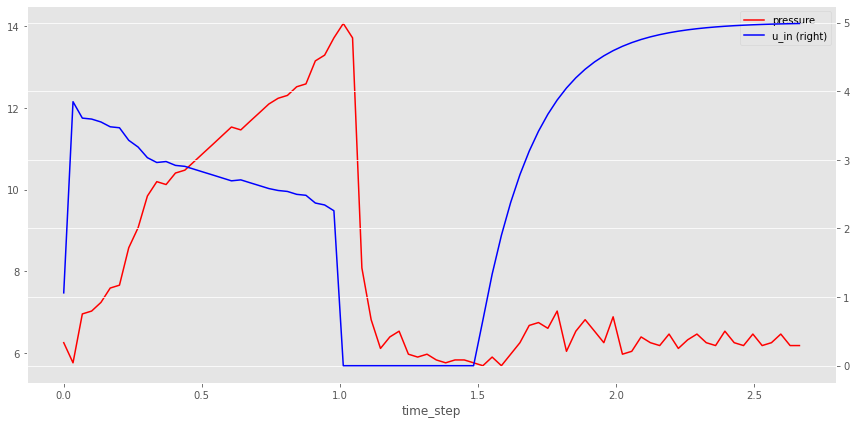

In [26]:
plot_breath(dfp_train[dfp_train["breath_id"] == 23], ["u_in"])

In [27]:
dfp_train_merge_RC_u_in_agg = pd.concat([dfp_train_RC_agg, dfp_train_u_in_agg], axis=1)

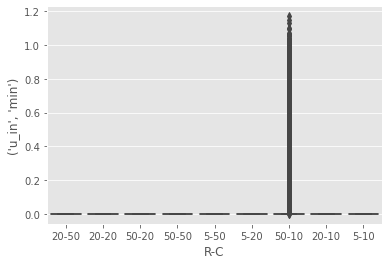

In [28]:
import seaborn as sns

ax = sns.boxplot(x="R-C", y=("u_in", "min"), data=dfp_train_merge_RC_u_in_agg)

build normalisation based on max and keep max u_in coul be a good feature

## Build new features

In [46]:
%%time
def build_new_features(dfp_data):
    
    #Build max features
    dfp_max_features = dfp_data.groupby(["breath_id"]).agg({"u_in" : ["max", "min"]}).reset_index()
    dfp_max_features.columns = ["breath_id", "max_u_in", "min_u_in"]
    dfp_max_features["delta_u_in"] = dfp_max_features["max_u_in"] - dfp_max_features["min_u_in"]
    
    # Get the 
    dfp_data_u_out_process = dfp_data[dfp_data["u_out"] == 1].groupby("breath_id").agg({"time_step" : "min"}).reset_index()
    dfp_data_u_out_process.columns = ["breath_id", "time_step_threshold"]
    
    # build indicator
    dfp_data["R-C"] = dfp_data.apply(lambda row: f'{row["R"]}-{row["C"]}', axis=1)
    
    dfp_data = pd.merge(dfp_data, dfp_max_features, on=["breath_id"])
    dfp_data["u_in_norm"] = dfp_data["max_u_in"] - dfp_data["u_in"] 
    dfp_data["u_in_norm"] = dfp_data.apply(lambda row: (1.0 - (row["u_in_norm"] / row["delta_u_in"])) if row["delta_u_in"] != 0 else 1.0 - row["u_in_norm"], axis=1)
    dfp_data = pd.merge(dfp_data, dfp_data_u_out_process, on=["breath_id"])
    dfp_data["u_out_threshold_reached"] = dfp_data["time_step"] - dfp_data["time_step_threshold"]
    dfp_data["u_out_threshold_reached"] = dfp_data["u_out_threshold_reached"].apply(lambda value: 0 if value < 0 else value)
    del dfp_data["time_step_threshold"]
    
    dfp_data.sort_values(["breath_id", "time_step"], inplace=True)
    for s in [1, 2, 4]:
        dfp_data[f"u_in_norm_delta_{s}"] = dfp_data.groupby("breath_id")["u_in_norm"].apply(lambda x: x - x.shift(s))
        dfp_data[f"u_in_norm_delta_{s}"].fillna(0, inplace=True)
        
        dfp_data[f"time_step_delta_{s}"] = dfp_data.groupby("breath_id")["time_step"].apply(lambda x: x - x.shift(s))
        dfp_data[f"time_step_delta_{s}"].fillna(0, inplace=True)
        
        dfp_data[f"u_in_norm_trend_{s}"] = dfp_data.apply(lambda row: row[f"u_in_norm_delta_{s}"]/row[f"time_step_delta_{s}"] if row[f"time_step_delta_{s}"] > 0 else 0, axis=1)
        
    return dfp_data
    
dfp_train_upgraded = build_new_features(dfp_train)
dfp_test_upgraded = build_new_features(dfp_test)

CPU times: user 12min 15s, sys: 11.7 s, total: 12min 26s
Wall time: 12min 26s


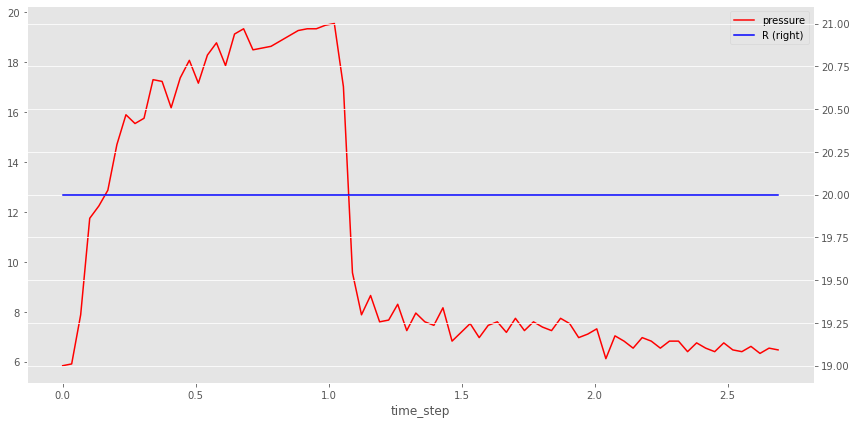

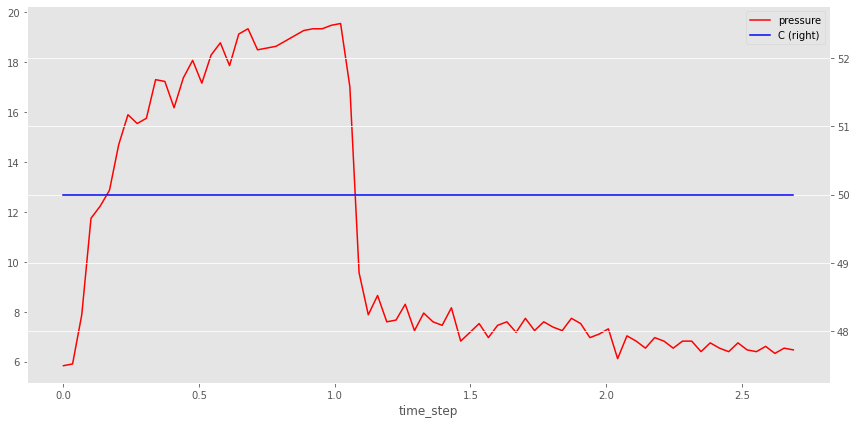

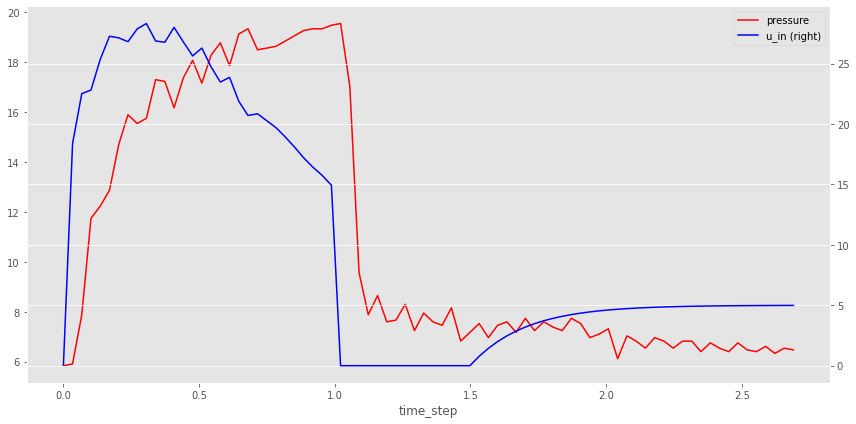

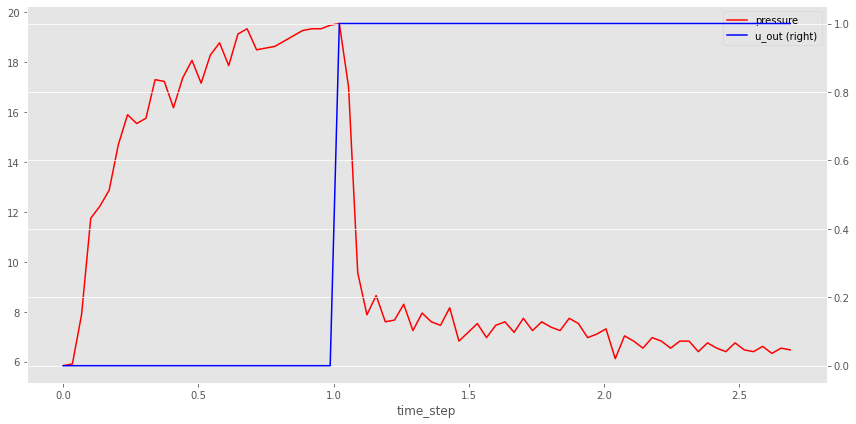

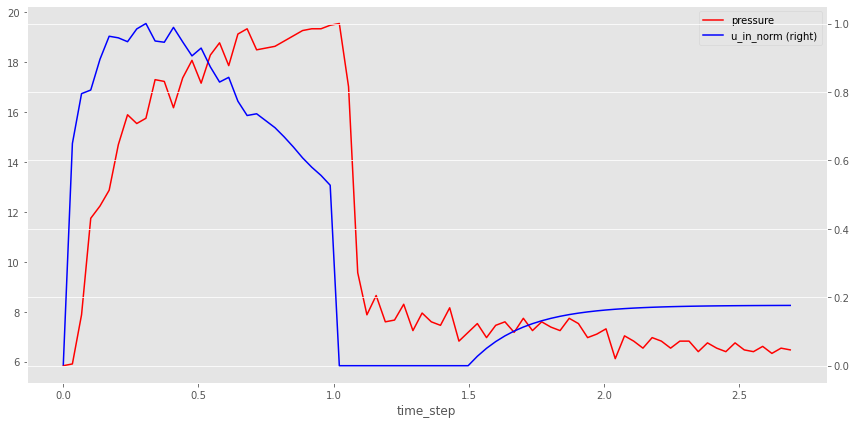

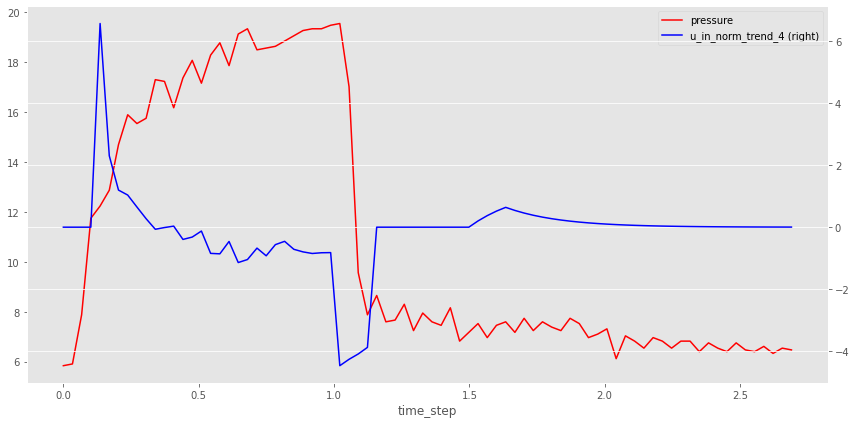

In [47]:
plot_breath(dfp_train_upgraded[dfp_train_upgraded["breath_id"] == 1], columns=["R","C", "u_in","u_out","u_in_norm", "u_in_norm_trend_4"])

In [48]:
columns_selected = ["id", "breath_id", "R-C", "max_u_in", "min_u_in", "u_in_norm", "u_in_norm_trend_1", "u_in_norm_trend_2", "u_in_norm_trend_4", "u_out", "u_out_threshold_reached", "time_step"]
dfp_train_upgraded[columns_selected + ["pressure"]].to_csv("./data/updated_datasets/train_20211004.csv", index=None)
dfp_test_upgraded[columns_selected].to_csv("./data/updated_datasets/test_20211004.csv", index=None)

In [231]:
dfp_train_upgraded["u_in_norm_trend"] = dfp_train_upgraded.groupby("breath_id")["u_in_norm"].apply(lambda x: x.pct_change().mean())
dfp_train_upgraded["u_in_norm_trend"].fillna(0, inplace=True)

In [229]:
dfp_train_upgraded.iloc[0]

id                                  1
breath_id                           1
R                                  20
C                                  50
time_step                           0
u_in                         0.083334
u_out                               0
pressure                      5.83749
rm_pressure                   5.83749
R-C                             20-50
max_u_in                       28.313
min_u_in                            0
delta_u_in                     28.313
u_in_norm                  0.00294331
u_out_threshold_reached             0
u_in_norm_trend                     0
Name: 0, dtype: object

In [ ]:
dfp_train.isnull().sum()

In [ ]:
agg_func = {
    "R" : ["mean","std","min","max"],
    "C" : ["mean","std","min","max"],
    "time_step" : ["mean","std","min","max"],
    "u_in" : ["mean","std","min","max"],
    "u_out" : ["mean","std","min","max"],
}

def build_agg_stats(dfp_train, agg_func):
    dfp_train_overall_stats_agg = dfp_train.groupby(["breath_id"]).agg(agg_func)
    dfp_train_overall_stats_agg.columns = [f"{elt[1]}-{elt[0]}" for elt in dfp_train_overall_stats_agg.columns]
    dfp_train_size_agg = dfp_train.groupby(["breath_id"]).size().to_frame()
    dfp_train_size_agg.columns = ["count_records"]
    dfp_train_overall_stats_agg = pd.concat([dfp_train_overall_stats_agg, dfp_train_size_agg], axis=1)
    return dfp_train_overall_stats_agg

dfp_train_overall_stats_agg = build_agg_stats(dfp_train, agg_func)
dfp_test_overall_stats_agg = build_agg_stats(dfp_test, agg_func)

In [87]:
dfp_test_overall_stats_agg.sample(frac=0.1).head()

,mean-R,std-R,min-R,max-R,mean-C,std-C,min-C,max-C,mean-time_step,std-time_step,...,max-time_step,mean-u_in,std-u_in,min-u_in,max-u_in,mean-u_out,std-u_out,min-u_out,max-u_out,count_records
breath_id,,,,,,,,,,,,,,,,,,,,,
104510,5,0.0,5,5,10,0.0,10,10,1.332776,0.784072,...,2.665214,4.318363,2.863532,0.0,10.474604,0.6250,0.487177,0,1,80
39012,50,0.0,50,50,10,0.0,10,10,1.318235,0.775620,...,2.636292,4.595959,7.145202,0.0,37.746440,0.6250,0.487177,0,1,80
42971,5,0.0,5,5,20,0.0,20,20,1.258711,0.740896,...,2.518733,12.067492,12.533477,0.0,33.382629,0.6000,0.492989,0,1,80
119808,5,0.0,5,5,20,0.0,20,20,1.258355,0.740553,...,2.517178,11.160532,12.021009,0.0,43.971036,0.6000,0.492989,0,1,80
22983,5,0.0,5,5,50,0.0,50,50,1.345212,0.791703,...,2.691089,25.230416,36.696237,0.0,100.000000,0.6375,0.483755,0,1,80


In [86]:
for key, func in agg_func.items():
    print(key)
    columns = [f"{elt}-{key}"for elt in func]
    dfp_train_overall_stats_agg_key = dfp_train_overall_stats_agg[columns]
    stats_features = dfp_train_overall_stats_agg_key.describe().loc["std"] 
    features_variable = stats_features[stats_features > 0].index.tolist()
    print(features_variable)

R
['mean-R', 'min-R', 'max-R']
C
['mean-C', 'min-C', 'max-C']
time_step
['mean-time_step', 'std-time_step', 'max-time_step']
u_in
['mean-u_in', 'std-u_in', 'min-u_in', 'max-u_in']
u_out
['mean-u_out', 'std-u_out']


In [123]:
dfp_evaluation_pressure = dfp_train.groupby(["breath_id"]).agg({"pressure" : ["mean","std","min","max"]})
dfp_evaluation_pressure.columns = [f"{elt[1]}-{elt[0]}" for elt in dfp_evaluation_pressure.columns]
dfp_evaluation_pressure["max-min_pressure"] = dfp_evaluation_pressure["max-pressure"] - dfp_evaluation_pressure["min-pressure"]

In [124]:
dfp_evaluation_pressure

,mean-pressure,std-pressure,min-pressure,max-pressure,max-min_pressure
breath_id,,,,,
1,10.841247,5.135058,5.837492,19.546410,13.708918
2,9.334145,4.365212,4.993866,18.562180,13.568314
3,13.534698,8.599539,5.064168,27.842063,22.777895
4,13.914329,10.388633,5.767190,40.496449,34.729260
5,9.666322,4.647055,4.853262,19.405806,14.552544
...,...,...,...,...,...
125740,7.815618,2.367756,5.345377,15.398583,10.053207
125742,15.216677,11.205411,5.626585,34.872278,29.245693
125743,7.597682,2.035167,5.485981,11.110153,5.624172


In [131]:
dfp_train["rm_pressure"] = dfp_train.sort_values(["breath_id", "time_step"]).groupby("breath_id")["pressure"].transform(lambda x: x.rolling(5, 1).mean())

In [134]:
breath_id = random.choice(breath_ids)
dfp_train_breath_id = dfp_train[dfp_train["breath_id"] == breath_id]

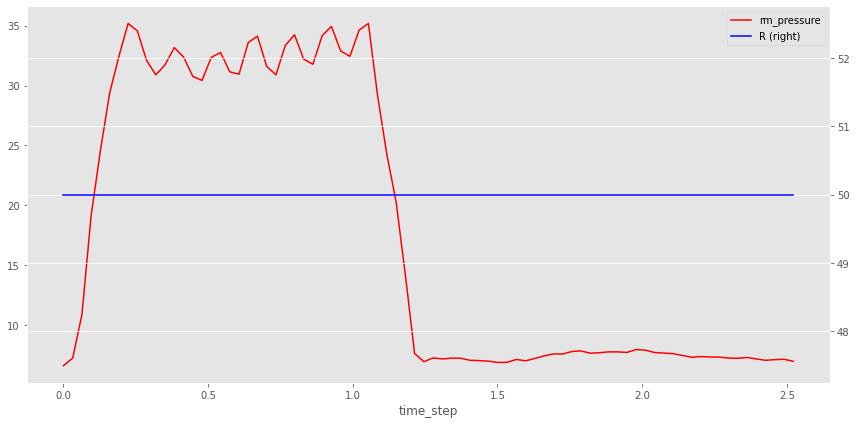

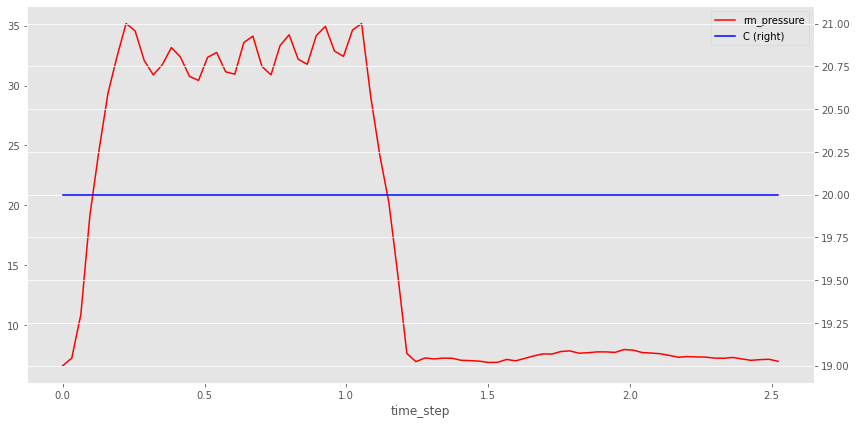

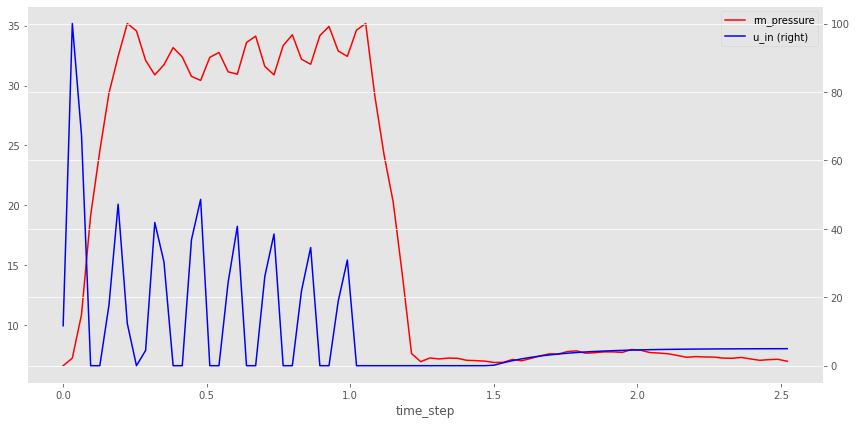

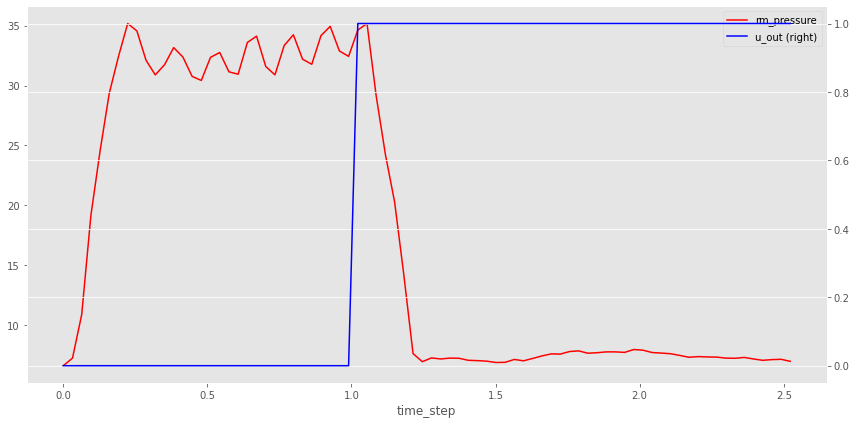

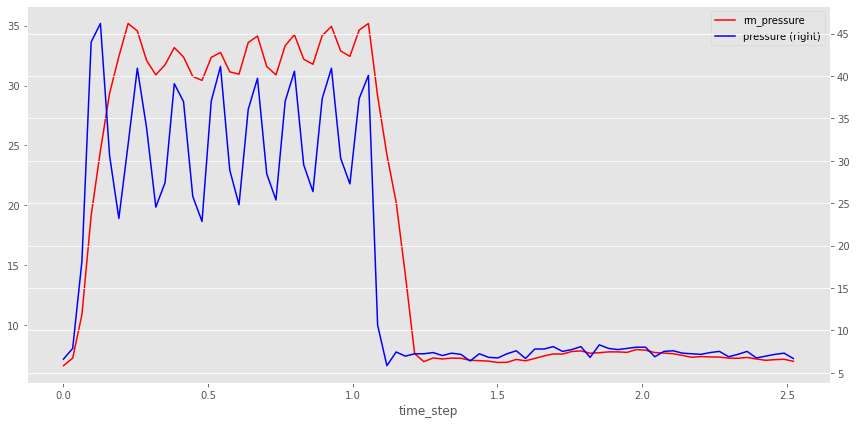

In [135]:
for column in ["R","C", "u_in","u_out","pressure"]:
    fig,ax=plt.subplots(figsize=(12,6))
    dfp_train_breath_id.plot(ax=ax, x="time_step", y="rm_pressure", color="r")
    dfp_train_breath_id.plot(ax=ax, x="time_step", y=column, color="b", secondary_y=True)
    fig.tight_layout()
    plt.show()